In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!git clone https://github.com/NVlabs/stylegan
!git clone https://github.com/jacobhallberg/pytorch_stylegan_encoder/
!cp stylegan/* . -r
!cp -r pytorch_stylegan_encoder/* .

Cloning into 'stylegan'...
remote: Enumerating objects: 83, done.
remote: Total 83 (delta 0), reused 0 (delta 0), pack-reused 83
Unpacking objects: 100% (83/83), done.
Cloning into 'pytorch_stylegan_encoder'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 358 (delta 40), reused 15 (delta 6), pack-reused 287
Receiving objects: 100% (358/358), 56.89 MiB | 17.52 MiB/s, done.
Resolving deltas: 100% (179/179), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!rm -r bedrooms
!mkdir bedrooms
!find /content/drive/My\ Drive/Kaggle/data0/lsun/bedroom/1/1/1 \( -name "*.png" -or -name "*.jpg" \) -exec cp {} bedrooms \;

In [ ]:
import os

# PyTorch implementation of the StyleGAN Generator
*by Piotr Bialecki and Thomas Viehmann*

We implement the generator of *T. Karras et al., A Style-Based Generator Architecture for Generative Adversarial Networks* in PyTorch. 

StyleGAN's photorealistic faces are an intriguing GAN output.
While diving deep into the architecture we found that a good way to do this, is to provide a simple notebook which recreates the StyleGAN for use with the pretrained weights.

Also we can always learn a few tricks when doing something as this, let's take a look.

[Karras et al. provide a reference implementation and links to weights, paper, and video](https://github.com/NVlabs/stylegan).

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import OrderedDict
import pickle

import numpy as np

import IPython


### Anything new in the linear layer?

Did you just yawn, when you saw linear layer? Not so fast!

There is a trick that is maybe not as well known (I should be grateful if anyone pointed out a reference): While it is very common to use targeted initialization such as the method of K. He (`torch.nn.kaiming_normal_` and `torch.nn.kaiming_normal_`), if we actually don't scale the parameter but multiply the factor separately, the same factor also scales the gradients and thus, for methods like stochastic gradient descent (SGD) the updates. (For optimizers that remove scaling such as Adam, one would expect the effect to cancel with the modification in Adam's scaling.)

Vaguely connected, [H Zhang et al. *Fixup Initialization: Residual Learning Without Normalization*](https://openreview.net/forum?id=H1gsz30cKX) suggest to have (but trainable) scalar multipliers.

So here is the linear layer.

In [ ]:
class MyLinear(nn.Module):
    """Linear layer with equalized learning rate and custom learning rate multiplier."""
    def __init__(self, input_size, output_size, gain=2**(0.5), use_wscale=False, lrmul=1, bias=True):
        super().__init__()
        he_std = gain * input_size**(-0.5) # He init
        # Equalized learning rate and custom learning rate multiplier.
        if use_wscale:
            init_std = 1.0 / lrmul
            self.w_mul = he_std * lrmul
        else:
            init_std = he_std / lrmul
            self.w_mul = lrmul
        self.weight = torch.nn.Parameter(torch.randn(output_size, input_size) * init_std)
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(output_size))
            self.b_mul = lrmul
        else:
            self.bias = None

    def forward(self, x):
        bias = self.bias
        if bias is not None:
            bias = bias * self.b_mul
        return F.linear(x, self.weight * self.w_mul, bias)

### Convolution Layer

The convolution layer uses the same trick as the linear layer.

As the architecture of StyleGAN prescribes that during upscaling, blurring occurs between bias addition and (I didn't look into detail why it doesn't seem to commute), we need to provide a mechanism to have an intermediate step between them.
For larger resolutions, the authors also propose a fused convolution / upscaling which is *not* equivalent to the two separate operations. (The "averaging" of the weight isn't actually an average, but an addition, that would seem to effectively multiply the weight by four, but I don't know how compatible it would be even without this effect.)

If we don't have the two, we use the regular convolution with bias.

In [ ]:
class MyConv2d(nn.Module):
    """Conv layer with equalized learning rate and custom learning rate multiplier."""
    def __init__(self, input_channels, output_channels, kernel_size, gain=2**(0.5), use_wscale=False, lrmul=1, bias=True,
                intermediate=None, upscale=False):
        super().__init__()
        if upscale:
            self.upscale = Upscale2d()
        else:
            self.upscale = None
        he_std = gain * (input_channels * kernel_size ** 2) ** (-0.5) # He init
        self.kernel_size = kernel_size
        if use_wscale:
            init_std = 1.0 / lrmul
            self.w_mul = he_std * lrmul
        else:
            init_std = he_std / lrmul
            self.w_mul = lrmul
        self.weight = torch.nn.Parameter(torch.randn(output_channels, input_channels, kernel_size, kernel_size) * init_std)
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(output_channels))
            self.b_mul = lrmul
        else:
            self.bias = None
        self.intermediate = intermediate

    def forward(self, x):
        bias = self.bias
        if bias is not None:
            bias = bias * self.b_mul
        
        have_convolution = False
        if self.upscale is not None and min(x.shape[2:]) * 2 >= 128:
            # this is the fused upscale + conv from StyleGAN, sadly this seems incompatible with the non-fused way
            # this really needs to be cleaned up and go into the conv...
            w = self.weight * self.w_mul
            w = w.permute(1, 0, 2, 3)
            # probably applying a conv on w would be more efficient. also this quadruples the weight (average)?!
            w = F.pad(w, (1,1,1,1))
            w = w[:, :, 1:, 1:]+ w[:, :, :-1, 1:] + w[:, :, 1:, :-1] + w[:, :, :-1, :-1]
            x = F.conv_transpose2d(x, w, stride=2, padding=(w.size(-1)-1)//2)
            have_convolution = True
        elif self.upscale is not None:
            x = self.upscale(x)
    
        if not have_convolution and self.intermediate is None:
            return F.conv2d(x, self.weight * self.w_mul, bias, padding=self.kernel_size//2)
        elif not have_convolution:
            x = F.conv2d(x, self.weight * self.w_mul, None, padding=self.kernel_size//2)
        
        if self.intermediate is not None:
            x = self.intermediate(x)
        if bias is not None:
            x = x + bias.view(1, -1, 1, 1)
        return x

### Noise Layer

The noise layer adds gaussian noise of learnable standard deviation (and zero mean). The noise itself is per-pixel (and image in the minibatch), but constant over the channels. Note that the learnable standard deviation is per channel.
As you can see when you feed the same latent into the model several times, the effects are not all that large, but in the detail.

There is a little trick in the code: if you set .noise for the noise layer, you can fix the noise. This is one of the tricks to use when checking against a reference implementation - this way you can get a 1-1 correspondence of outputs.

In [ ]:
class NoiseLayer(nn.Module):
    """adds noise. noise is per pixel (constant over channels) with per-channel weight"""
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(channels))
        self.noise = None
    
    def forward(self, x, noise=None):
        if noise is None and self.noise is None:
            noise = torch.randn(x.size(0), 1, x.size(2), x.size(3), device=x.device, dtype=x.dtype) * 0
        elif noise is None:
            # here is a little trick: if you get all the noiselayers and set each
            # modules .noise attribute, you can have pre-defined noise.
            # Very useful for analysis
            noise = self.noise
        x = x + self.weight.view(1, -1, 1, 1) * noise
        return x  

### Style Modification layer

In the generator, a style modification layer is used after each (non-affine) instance norm layer. Recall that the instance norm normalizes the mean and standard deviation across pixels separately for each channel (and sample).
So here we put back a mean and variance, but not just arbitrary learnable parameters, but as the output of a linear layer which takes the latent style vector as inputs. So in a way, this is the affine part of the instance norm, but with calculated parameters.
The article call the affine Instance Norm *Adaptive Instance Norm (AdaIN)*.

In [ ]:
class StyleMod(nn.Module):
    def __init__(self, latent_size, channels, use_wscale):
        super(StyleMod, self).__init__()
        self.lin = MyLinear(latent_size,
                            channels * 2,
                            gain=1.0, use_wscale=use_wscale)
        
    def forward(self, x, latent):
        style = self.lin(latent) # style => [batch_size, n_channels*2]
        shape = [-1, 2, x.size(1)] + (x.dim() - 2) * [1]
        style = style.view(shape)  # [batch_size, 2, n_channels, ...]
        x = x * (style[:, 0] + 1.) + style[:, 1]
        return x

### Pixelnorm

Pixelnorm normalizes per pixel across all channels.

Note that the default configuration only use the pixel norm in the g_mapping. There it effectively forces the empirical standard deviation of the latent vector to be one.

In [ ]:
class PixelNormLayer(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon
    def forward(self, x):
        return x * torch.rsqrt(torch.mean(x**2, dim=1, keepdim=True) + self.epsilon)

# Upscale and blur layers

The StyleGAN has two types of upscaling. For the plain one, where you just set a block of 2x2 pixels to the value of the pixel to arrive an image that is scaled by 2. No fancy stuff like bilinear or bicubic interpolation. The alternative way - "fused" with convolution - uses a stride 2 transposed convolution instead. Note from above that they seem to not be quite equivalent (at least not with the same parametrisation).
Both of these will have blocky results. To mitigate, the generator blurs the layer, by convolving with the simplest possible smoothing kernel.


In [ ]:
class BlurLayer(nn.Module):
    def __init__(self, kernel=[1, 2, 1], normalize=True, flip=False, stride=1):
        super(BlurLayer, self).__init__()
        kernel=[1, 2, 1]
        kernel = torch.tensor(kernel, dtype=torch.float32)
        kernel = kernel[:, None] * kernel[None, :]
        kernel = kernel[None, None]
        if normalize:
            kernel = kernel / kernel.sum()
        if flip:
            kernel = kernel[:, :, ::-1, ::-1]
        self.register_buffer('kernel', kernel)
        self.stride = stride
    
    def forward(self, x):
        # expand kernel channels
        kernel = self.kernel.expand(x.size(1), -1, -1, -1)
        x = F.conv2d(
            x,
            kernel,
            stride=self.stride,
            padding=int((self.kernel.size(2)-1)/2),
            groups=x.size(1)
        )
        return x

def upscale2d(x, factor=2, gain=1):
    assert x.dim() == 4
    if gain != 1:
        x = x * gain
    if factor != 1:
        shape = x.shape
        x = x.view(shape[0], shape[1], shape[2], 1, shape[3], 1).expand(-1, -1, -1, factor, -1, factor)
        x = x.contiguous().view(shape[0], shape[1], factor * shape[2], factor * shape[3])
    return x

class Upscale2d(nn.Module):
    def __init__(self, factor=2, gain=1):
        super().__init__()
        assert isinstance(factor, int) and factor >= 1
        self.gain = gain
        self.factor = factor
    def forward(self, x):
        return upscale2d(x, factor=self.factor, gain=self.gain)

### Generator Mapping Module

With all these building blocks done, we can actually define the StyleGAN generator.
The fist component is the mapping. It's a reasonably deep (8 layers) but otherwise very plain vanilla fully connected network aka Multi-Layer-Perceptron. The StyleGAN reference model uses Leaky ReLUs, so we do, too.
Note that while we get an 18-channel (times 512 features) per image style matrix, all 18 channels will be the same. 

We also provide a truncation module pulling the upper layer's latent inputs towards the mean, but we don't activate it as the mean is not provided in the pre-trained network. We could run the mapping for a while and derive the truncation weights.

In [ ]:
class G_mapping(nn.Sequential):
    def __init__(self, nonlinearity='lrelu', use_wscale=True):
        act, gain = {'relu': (torch.relu, np.sqrt(2)),
                     'lrelu': (nn.LeakyReLU(negative_slope=0.2), np.sqrt(2))}[nonlinearity]
        layers = [
            ('pixel_norm', PixelNormLayer()),
            ('dense0', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense0_act', act),
            ('dense1', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense1_act', act),
            ('dense2', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense2_act', act),
            ('dense3', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense3_act', act),
            ('dense4', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense4_act', act),
            ('dense5', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense5_act', act),
            ('dense6', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense6_act', act),
            ('dense7', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense7_act', act)
        ]
        super().__init__(OrderedDict(layers))
        
    def forward(self, x):
        x = super().forward(x)
        # Broadcast
        x = x.unsqueeze(1).expand(-1, 14, -1)
        return x

class Truncation(nn.Module):
    def __init__(self, avg_latent, max_layer=8, threshold=0.7):
        super().__init__()
        self.max_layer = max_layer
        self.threshold = threshold
        self.register_buffer('avg_latent', avg_latent)
    def forward(self, x):
        assert x.dim() == 3
        interp = torch.lerp(self.avg_latent, x, self.threshold)
        do_trunc = (torch.arange(x.size(1)) < self.max_layer).view(1, -1, 1)
        return torch.where(do_trunc, interp, x)

### Generator Synthesis Blocks

Each Block consists of two halfs. Each of these halfs does the following:
- Upscaling (if it's the first half) by a factor of two and blurring - fused with the convolution for the later layers
- Convolution (if it's the first half, halving the channels for the later layers)
- Noise
- Activation (LeakyReLU in the reference model)
- Optionally Pixel Norm (**not used** in the reference model)
- Instance Norm (optional, but used in the reference model)
- The style modulation (i.e. setting the mean/standard deviation of the outputs after instance norm, see above)

Two of these sequences form a block that typically has `out_channels = in_channels//2` (in the earlier blocks, there are 512 input and 512 output channels) and `output_resolution = input_resolution * 2`.
We combine all but the first two into a Module called the Layer Epilogue (the term taken from the original code).
Note that the original implementation moves the bias of the convolution after the noise, but those two commute, so it doesn't matter.

The first block (4x4 "pixels") doesn't have an input. The result of the first convolution is just replaced by a (trained) constant. We call it the `InputBlock`, the others `GSynthesisBlock`.
(It might be nicer to do this the other way round, i.e. have the `LayerEpilogue` be the Layer and call the conv from that.)

In [ ]:
class LayerEpilogue(nn.Module):
    """Things to do at the end of each layer."""
    def __init__(self, channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        super().__init__()
        layers = []
        if use_noise:
            layers.append(('noise', NoiseLayer(channels)))
        layers.append(('activation', activation_layer))
        if use_pixel_norm:
            layers.append(('pixel_norm', PixelNorm()))
        if use_instance_norm:
            layers.append(('instance_norm', nn.InstanceNorm2d(channels)))
        self.top_epi = nn.Sequential(OrderedDict(layers))
        if use_styles:
            self.style_mod = StyleMod(dlatent_size, channels, use_wscale=use_wscale)
        else:
            self.style_mod = None
    def forward(self, x, dlatents_in_slice=None):
        x = self.top_epi(x)
        if self.style_mod is not None:
            x = self.style_mod(x, dlatents_in_slice)
        else:
            assert dlatents_in_slice is None
        return x


class InputBlock(nn.Module):
    def __init__(self, nf, dlatent_size, const_input_layer, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        super().__init__()
        self.const_input_layer = const_input_layer
        self.nf = nf
        if self.const_input_layer:
            # called 'const' in tf
            self.const = nn.Parameter(torch.ones(1, nf, 4, 4))
            self.bias = nn.Parameter(torch.ones(nf))
        else:
            self.dense = MyLinear(dlatent_size, nf*16, gain=gain/4, use_wscale=use_wscale) # tweak gain to match the official implementation of Progressing GAN
        self.epi1 = LayerEpilogue(nf, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
        self.conv = MyConv2d(nf, nf, 3, gain=gain, use_wscale=use_wscale)
        self.epi2 = LayerEpilogue(nf, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
        
    def forward(self, dlatents_in_range):
        batch_size = dlatents_in_range.size(0)
        if self.const_input_layer:
            x = self.const.expand(batch_size, -1, -1, -1)
            x = x + self.bias.view(1, -1, 1, 1)
        else:
            x = self.dense(dlatents_in_range[:, 0]).view(batch_size, self.nf, 4, 4)
        x = self.epi1(x, dlatents_in_range[:, 0])
        x = self.conv(x)
        x = self.epi2(x, dlatents_in_range[:, 1])
        return x


class GSynthesisBlock(nn.Module):
    def __init__(self, in_channels, out_channels, blur_filter, dlatent_size, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        # 2**res x 2**res # res = 3..resolution_log2
        super().__init__()
        if blur_filter:
            blur = BlurLayer(blur_filter)
        else:
            blur = None
        self.conv0_up = MyConv2d(in_channels, out_channels, kernel_size=3, gain=gain, use_wscale=use_wscale,
                                 intermediate=blur, upscale=True)
        self.epi1 = LayerEpilogue(out_channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
        self.conv1 = MyConv2d(out_channels, out_channels, kernel_size=3, gain=gain, use_wscale=use_wscale)
        self.epi2 = LayerEpilogue(out_channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
            
    def forward(self, x, dlatents_in_range):
        x = self.conv0_up(x)
        x = self.epi1(x, dlatents_in_range[:, 0])
        x = self.conv1(x)
        x = self.epi2(x, dlatents_in_range[:, 1])
        return x

# Generator - Synthesis part

Finally, the synthesis part just stacks 9 blocks (input + 8 resolution doubling) and a pixelwise (1x1) convolution from 16 channels to RGB (3 channels).
Note that lower resolution RGB convolutions don't seem to serve any purpose in the final model. (And we don't think that they produce images as they once did during the training - but the parameter file contains parameters, so we have the modules here. The alternative would be to filter out the weights).
The reference implementation's somewhat convoluted setup in the "recursive" mode is mainly to provide a single static graph for all stages of the progressive training. It would be interesting to reimplement the full training in PyTorch, making use of the dynamic graphs.


In [ ]:
class G_synthesis(nn.Module):
    def __init__(self,
        dlatent_size        = 512,          # Disentangled latent (W) dimensionality.
        num_channels        = 3,            # Number of output color channels.
        resolution          = 256,         # Output resolution.
        fmap_base           = 8192,         # Overall multiplier for the number of feature maps.
        fmap_decay          = 1.0,          # log2 feature map reduction when doubling the resolution.
        fmap_max            = 512,          # Maximum number of feature maps in any layer.
        use_styles          = True,         # Enable style inputs?
        const_input_layer   = True,         # First layer is a learned constant?
        use_noise           = True,         # Enable noise inputs?
        randomize_noise     = True,         # True = randomize noise inputs every time (non-deterministic), False = read noise inputs from variables.
        nonlinearity        = 'lrelu',      # Activation function: 'relu', 'lrelu'
        use_wscale          = True,         # Enable equalized learning rate?
        use_pixel_norm      = False,        # Enable pixelwise feature vector normalization?
        use_instance_norm   = True,         # Enable instance normalization?
        dtype               = torch.float32,  # Data type to use for activations and outputs.
        blur_filter         = [1,2,1],      # Low-pass filter to apply when resampling activations. None = no filtering.
        ):
        
        super().__init__()
        def nf(stage):
            return min(int(fmap_base / (2.0 ** (stage * fmap_decay))), fmap_max)
        self.dlatent_size = dlatent_size
        resolution_log2 = int(np.log2(resolution))
        assert resolution == 2**resolution_log2 and resolution >= 4

        act, gain = {'relu': (torch.relu, np.sqrt(2)),
                     'lrelu': (nn.LeakyReLU(negative_slope=0.2), np.sqrt(2))}[nonlinearity]
        num_layers = resolution_log2 * 2 - 2
        num_styles = num_layers if use_styles else 1
        torgbs = []
        blocks = []
        for res in range(2, resolution_log2 + 1):
            channels = nf(res-1)
            name = '{s}x{s}'.format(s=2**res)
            if res == 2:
                blocks.append((name,
                               InputBlock(channels, dlatent_size, const_input_layer, gain, use_wscale,
                                      use_noise, use_pixel_norm, use_instance_norm, use_styles, act)))
                
            else:
                blocks.append((name,
                               GSynthesisBlock(last_channels, channels, blur_filter, dlatent_size, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, act)))
            last_channels = channels
        self.torgb = MyConv2d(channels, num_channels, 1, gain=1, use_wscale=use_wscale)
        self.blocks = nn.ModuleDict(OrderedDict(blocks))
        
    def forward(self, dlatents_in):
        # Input: Disentangled latents (W) [minibatch, num_layers, dlatent_size].
        # lod_in = tf.cast(tf.get_variable('lod', initializer=np.float32(0), trainable=False), dtype)
        batch_size = dlatents_in.size(0)       
        for i, m in enumerate(self.blocks.values()):
            if i == 0:
                x = m(dlatents_in[:, 2*i:2*i+2])
            else:
                x = m(x, dlatents_in[:, 2*i:2*i+2])
        rgb = self.torgb(x)
        return rgb

## All done, let's define the model!

In [ ]:
g_all = nn.Sequential(OrderedDict([
    ('g_mapping', G_mapping()),
    #('truncation', Truncation(avg_latent)),
    ('g_synthesis', G_synthesis())    
]))

### But we need weights. Can we use the pretrained ones?

Yes, we can! The following can be used to convert them from author's format. We have already done this for you, and you can get the weights from 
[here](https://github.com/lernapparat/lernapparat/releases/download/v2019-02-01/karras2019stylegan-ffhq-1024x1024.for_g_all.pt).

Note that the weights are taken from [the reference implementation](https://github.com/NVlabs/stylegan) distributed by NVidia Corporation as Licensed under the CC-BY-NC 4.0 license. As such, the same applies here.

For completeness, our conversion is below, but you can skip it if you download the PyTorch-ready weights.

In [ ]:
if 1:
    # this can be run to get the weights, but you need the reference implementation and weights
    import dnnlib, dnnlib.tflib, pickle, torch, collections
    dnnlib.tflib.init_tf()
    weights = pickle.load(open('drive/My Drive/CV_project/karras2019stylegan-bedrooms-256x256.pkl','rb'))
    weights_pt = [collections.OrderedDict([(k, torch.from_numpy(v.value().eval())) for k,v in w.trainables.items()]) for w in weights]
    torch.save(weights_pt, './weights.pt')
if 1:
    # then on the PyTorch side run
    state_G, state_D, state_Gs = torch.load('./weights.pt')
    def key_translate(k):
        k = k.lower().split('/')
        if k[0] == 'g_synthesis':
            if not k[1].startswith('torgb'):
                k.insert(1, 'blocks')
            k = '.'.join(k)
            k = (k.replace('const.const','const').replace('const.bias','bias').replace('const.stylemod','epi1.style_mod.lin')
                  .replace('const.noise.weight','epi1.top_epi.noise.weight')
                  .replace('conv.noise.weight','epi2.top_epi.noise.weight')
                  .replace('conv.stylemod','epi2.style_mod.lin')
                  .replace('conv0_up.noise.weight', 'epi1.top_epi.noise.weight')
                  .replace('conv0_up.stylemod','epi1.style_mod.lin')
                  .replace('conv1.noise.weight', 'epi2.top_epi.noise.weight')
                  .replace('conv1.stylemod','epi2.style_mod.lin')
                  .replace('torgb_lod0','torgb'))
        else:
            k = '.'.join(k)
        return k

    def weight_translate(k, w):
        k = key_translate(k)
        if k.endswith('.weight'):
            if w.dim() == 2:
                w = w.t()
            elif w.dim() == 1:
                pass
            else:
                assert w.dim() == 4
                w = w.permute(3, 2, 0, 1)
        return w

    # we delete the useless torgb filters
    param_dict = {key_translate(k) : weight_translate(k, v) for k,v in state_Gs.items() if 'torgb_lod' not in key_translate(k)}
    if 1:
        sd_shapes = {k : v.shape for k,v in g_all.state_dict().items()}
        param_shapes = {k : v.shape for k,v in param_dict.items() }

        for k in list(sd_shapes)+list(param_shapes):
            pds = param_shapes.get(k)
            sds = sd_shapes.get(k)
            if pds is None:
                print ("sd only", k, sds)
            elif sds is None:
                print ("pd only", k, pds)
            elif sds != pds:
                print ("mismatch!", k, pds, sds)

    g_all.load_state_dict(param_dict, strict=False) # needed for the blur kernels
    torch.save(g_all.state_dict(), './weights.pt')














Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
sd only g_synthesis.blocks.8x8.conv0_up.intermediate.kernel torch.Size([1, 1, 3, 3])
sd only g_synthesis.blocks.16x16.conv0_up.intermediate.kernel torch.Size([1, 1, 3, 3])
sd only g_synthesis.blocks.32x32.conv0_up.intermediate.kernel torch.Size([1, 1, 3, 3])
sd only g_synthesis.blocks.64x64.conv0_up.intermediate.kernel torch.Size([1, 1, 3, 3])
sd only g_synthesis.blocks.128x128.conv0_up.intermediate.kernel torch.Size([1, 1, 3, 3])
sd only g_synthesis.blocks.256x256.conv0_up.intermediate.kernel torch.Size([1, 1, 3, 3])


Let's load the weights.

In [ ]:
g_all.load_state_dict(torch.load('./weights.pt'))

<All keys matched successfully>

Now we're all set! Let's generate faces!

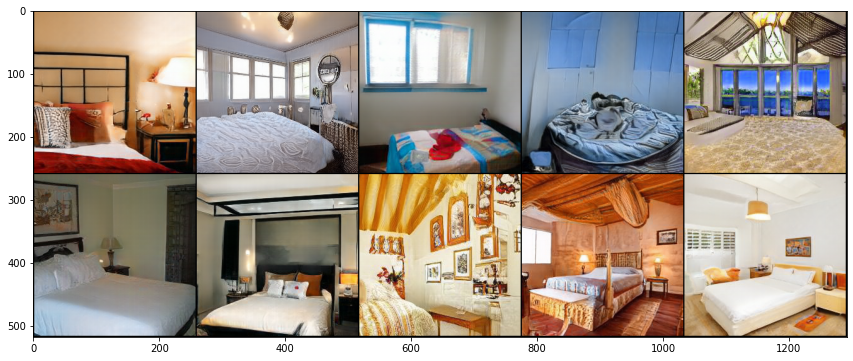

In [ ]:
%matplotlib inline
from matplotlib import pyplot
import torchvision
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
g_all.eval()
g_all.to(device)

torch.manual_seed(20)
nb_rows = 2
nb_cols = 5
nb_samples = nb_rows * nb_cols
latents = torch.randn(nb_samples, 512, device=device)
with torch.no_grad():
    imgs = g_all(latents)
    imgs = (imgs.clamp(-1, 1) + 1) / 2.0 # normalization to 0..1 range
imgs = imgs.cpu()

imgs = torchvision.utils.make_grid(imgs, nrow=nb_cols)

pyplot.figure(figsize=(15, 6))
pyplot.imshow(imgs.permute(1, 2, 0).detach().numpy())

# Interpolation

The fancy way to interpolate latents of same lengths is to find a path between them on the centered sphere they lie (see e.g. [Ken Shoemake: Animating Rotation with Quaternion Curves](https://arxiv.org/abs/1609.04468)
and this [slerp example](https://github.com/soumith/dcgan.torch/issues/14)).
However, because the pixel norm at the very beginning projects onto the sphere, we can just take linear interpolation at the expense of a interpolation speed that is a bit slower at the ends of the paths than in the middle.

In [ ]:
# Get a few Images
#nb_latents = 25
#nb_interp = 10
#fixed_latents = [torch.randn(1, 512, device=device) for _ in range(nb_interp)]
#latents = []
#for i in range(len(fixed_latents)-1):
#    latents.append(fixed_latents[i] + (fixed_latents[i + 1] - fixed_latents[i]) * torch.arange(0, 1, 0.1, device=device).unsqueeze(1))
#latents.append(fixed_latents[-1])
#latents = torch.cat(latents, dim=0)

#%matplotlib inline
#with torch.no_grad():
#    for latent in latents:
#        latent = latent.to(device)
#        img = g_all(latent.unsqueeze(0))
#        img = img.clamp_(-1, 1).add_(1).div_(2.0)        
#        img = img.detach().squeeze(0).cpu().permute(1, 2, 0).numpy()
#        
#        pyplot.imshow(img)
#        IPython.display.clear_output(True)
#        pyplot.show()

That is all for today. We hope you enjoyed this little walk-through.

We appreciate your feedback. Email us at Piotr <mail@pbialecki.de> and Thomas <tv@lernapparat.de>.

Also visit https://twitter.com/ptrblck_de and https://lernapparat.de/ for more great stuff.

In [ ]:
for i in g_all.parameters():
  i.requires_grad = False

In [ ]:
trainble = 0
ntrainble = 0
for i in g_all.g_synthesis.parameters():
  if i.requires_grad:
    trainble += 1
  else:
    ntrainble += 1

trainble, ntrainble

(0, 72)

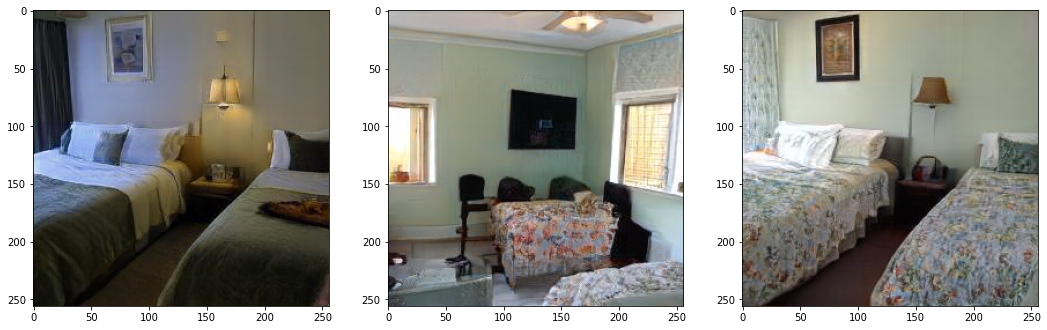

In [ ]:
torch.manual_seed(68)

latent1 = torch.randn(1, 512, device=device)
latent2 = torch.randn(1, 512, device=device)

rep = range(6, 14)

with torch.no_grad():
    dl1 = g_all.g_mapping(latent1)
    dl2 = g_all.g_mapping(latent2)
    dl3 = dl1.clone()
    dl3[:, rep, :] = dl2[:, rep, :]

    img1 = g_all.g_synthesis(dl1)[0]
    img2 = g_all.g_synthesis(dl2)[0]
    img3 = g_all.g_synthesis(dl3)[0]

    img1 = (img1.clamp(-1, 1) + 1) / 2.0 # normalization to 0..1 range
    img2 = (img2.clamp(-1, 1) + 1) / 2.0
    img3 = (img3.clamp(-1, 1) + 1) / 2.0

img1 = img1.cpu()
img2 = img2.cpu()
img3 = img3.cpu()

pyplot.figure(figsize=(18, 6))
pyplot.subplot(1, 3, 1)
pyplot.imshow(img1.permute(1, 2, 0).detach().numpy())
pyplot.subplot(1, 3, 2)
pyplot.imshow(img2.permute(1, 2, 0).detach().numpy())
pyplot.subplot(1, 3, 3)
pyplot.imshow(img3.permute(1, 2, 0).detach().numpy())
pyplot.show()

In [ ]:
from torchvision.models import resnet50


class myencoder(nn.Sequential):
    def __init__(self):
         super().__init__()
        
#         self.activation = torch.nn.ELU()

#         self.resnet = list(resnet50(pretrained=True).children())[:-2]
#         self.resnet = torch.nn.Sequential(*self.resnet)

#         for i in self.resnet.parameters():
#            i.requires_grad = False

#         self.conv2d = torch.nn.Conv2d(2048, 256, kernel_size=1)
         self.flatten = torch.nn.Flatten()
         self.dense1 = torch.nn.Linear(256 * 256 * 3, 512, bias = False)
         self.dense4 = torch.nn.Linear(512, (14 * 512), bias = False)

#        layers = [
#            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
#            nn.LeakyReLU(negative_slope=0.2),
#            nn.MaxPool2d(kernel_size= 2, stride = 2),

#            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
#            nn.LeakyReLU(negative_slope=0.2),
#            nn.MaxPool2d(kernel_size= 2, stride = 2),

#            nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
#            nn.LeakyReLU(negative_slope=0.2),
#            nn.MaxPool2d(kernel_size= 2, stride = 2),

#            nn.Conv2d(128, 256, kernel_size = 3, padding = 1),
#            nn.LeakyReLU(negative_slope=0.2),
#            nn.MaxPool2d(kernel_size= 2, stride = 2),

#            nn.Conv2d(256, 512, kernel_size = 3, padding = 1),
#            nn.LeakyReLU(negative_slope=0.2),
#            nn.MaxPool2d(kernel_size= 2, stride = 2),

#            nn.Flatten(),

#            nn.Linear(8 * 8 * 512, 512),
#            nn.LeakyReLU(negative_slope=0.2),

#            nn.Linear(512, 512),
#            nn.LeakyReLU(negative_slope=0.2),

#            nn.Linear(512, 512)
#        ]
#        lis = [(str(i), j) for i,j in enumerate(layers)]
#        super().__init__(OrderedDict(lis))
        
    def forward(self, x):
#        x = self.resnet(x)
#        x = self.conv2d(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense4(x)
        x = x.view((-1, 14, 512))

        return x
        
        #x = super().forward(x)
        # Broadcast
        #x = x.unsqueeze(1).expand(-1, 14, -1)
        #return x

encoder = myencoder()
encoder.cuda()

myencoder(
  (flatten): Flatten()
  (dense1): Linear(in_features=196608, out_features=512, bias=False)
  (dense4): Linear(in_features=512, out_features=7168, bias=False)
)

In [ ]:
autoencoder = nn.Sequential(OrderedDict([
    ('encoder', encoder),
    ('decoder', g_all.g_synthesis)    
]))

In [ ]:
import torch.nn.functional as F
from torchvision.models import vgg16
import torch

layer = 2
vgg = vgg16(pretrained = True)
vgg = nn.Sequential(*(list(vgg.children())[0][:layer + 1]))

for i in vgg.parameters():
    i.requires_grad = False

class PostSynthesisProcessing(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.min_value = -1
        self.max_value = 1

    def forward(self, synthesized_image):
        synthesized_image = (synthesized_image - self.min_value) * torch.tensor(255).float() / (self.max_value - self.min_value)

        return synthesized_image

class VGGProcessing(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.image_size = 256
        self.mean = torch.tensor([0.485, 0.456, 0.406], device="cuda").view(-1, 1, 1) * 255
        self.std = torch.tensor([0.229, 0.224, 0.225], device="cuda").view(-1, 1, 1) * 255

    def forward(self, image):
        image = (image - self.mean) / self.std

        return image

ae_vgg = nn.Sequential(OrderedDict([
    ('ae', autoencoder),
    ('p1', PostSynthesisProcessing()),
    ('p2', VGGProcessing()),
    ('vgg', vgg)
])
)

ae_vgg.cuda()

def myloss(pred, true, pred_l, true_l):
    o_f = vgg(true)
    return torch.mean((o_f - pred) ** 2) + torch.mean(torch.abs(pred_l - true_l)) * 512


loss = myloss
lr = 0.001
optimizer = torch.optim.Adam(encoder.parameters(), lr = lr)



In [ ]:
trainble = 0
ntrainble = 0
for i in ae_vgg.parameters():
  if i.requires_grad:
    trainble += 1
  else:
    ntrainble += 1

trainble, ntrainble

(2, 76)

In [ ]:
#encoder.load_state_dict(torch.load('drive/My Drive/encoder.pt'))

'''

epochs = 1000
batch_size = 16
loss_list = []

for i in range(epochs):
    latents = torch.randn(batch_size, 512, device=device)
    dlatents = g_all.g_mapping(latents)
    images = g_all.g_synthesis(dlatents)

    outputs_i = encoder(images)
    outputs = ae_vgg(images)

    l = loss(outputs, images, outputs_i, dlatents)
    loss_list.append(l.item())

    optimizer.zero_grad()
    l.backward()
    optimizer.step()

    print('Epoch ', i, '\t loss: ', loss_list[-1], '\t cum Loss ', sum(loss_list[-20:]) / 20)

    if (i + 1) % 100 == 0:
        torch.save(encoder.state_dict(), 'drive/My Drive/encoder.pt')

'''

"\n\nepochs = 1000\nbatch_size = 16\nloss_list = []\n\nfor i in range(epochs):\n    latents = torch.randn(batch_size, 512, device=device)\n    dlatents = g_all.g_mapping(latents)\n    images = g_all.g_synthesis(dlatents)\n\n    outputs_i = encoder(images)\n    outputs = ae_vgg(images)\n\n    l = loss(outputs, images, outputs_i, dlatents)\n    loss_list.append(l.item())\n\n    optimizer.zero_grad()\n    l.backward()\n    optimizer.step()\n\n    print('Epoch ', i, '\t loss: ', loss_list[-1], '\t cum Loss ', sum(loss_list[-20:]) / 20)\n\n    if (i + 1) % 100 == 0:\n        torch.save(encoder.state_dict(), 'drive/My Drive/encoder.pt')\n\n"

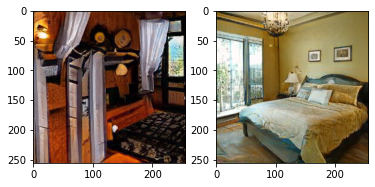

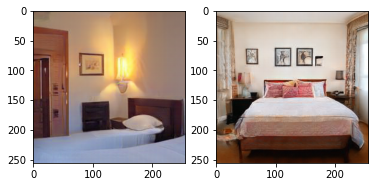

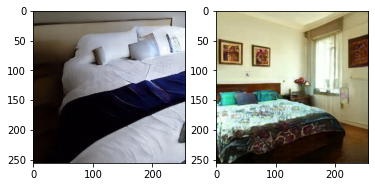

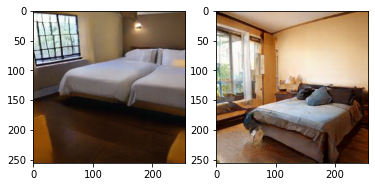

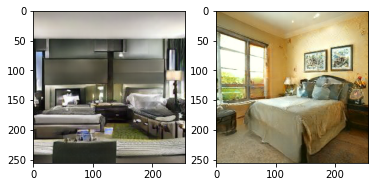

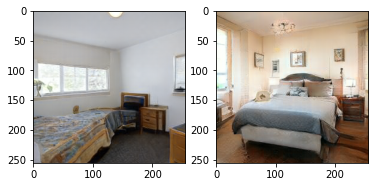

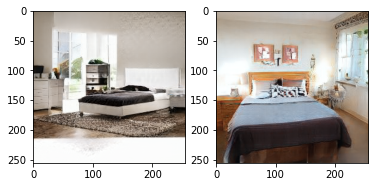

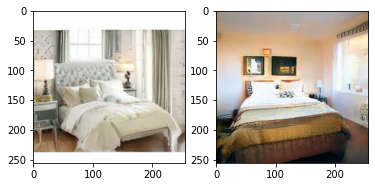

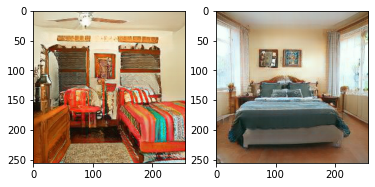

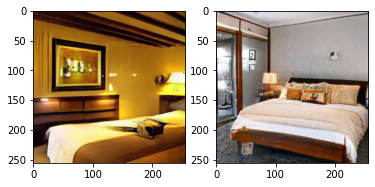

In [ ]:
n = 10

torch.manual_seed(12)

latents2 = torch.randn(n, 512, device=device)
dlatents2 = g_all.g_mapping(latents2)
images2 = g_all.g_synthesis(dlatents2)
outputs2 = encoder(images2)
images2_2 = g_all.g_synthesis(outputs2)

for i in range(len(images2)):
    pyplot.figure()
    pyplot.subplot(1, 2, 1)
    pyplot.imshow((images2[i].cpu().clamp(-1, 1).permute(1, 2, 0).detach().numpy() + 1) / 2) 
    pyplot.subplot(1, 2, 2)
    pyplot.imshow((images2_2[i].cpu().clamp(-1, 1).permute(1, 2, 0).detach().numpy() + 1) / 2)
pyplot.show()

In [ ]:
class mmmmodel(nn.Sequential):

    def __init__(self):
        super().__init__()
        self.dense1 = torch.nn.Linear(1, 512)
        self.dense2 = torch.nn.Linear(512, 512)
        self.dense3 = torch.nn.Linear(512, 512)
        self.dense4 = torch.nn.Linear(512, 512)
        self.dense5 = torch.nn.Linear(512, 512)
        self.dense6 = torch.nn.Linear(512, 512)
        self.dense7 = torch.nn.Linear(512, 512)
        self.dense8 = torch.nn.Linear(512, 512)
        
    def forward(self, x):
        x = self.dense1(x)
        x = nn.ReLU()(x)
        x = self.dense2(x)
        x = nn.ReLU()(x)
        x = self.dense3(x)
        x = nn.ReLU()(x)
        x = self.dense4(x)
        x = nn.ReLU()(x)
        x = self.dense5(x)
        x = nn.ReLU()(x)
        x = self.dense6(x)
        x = nn.ReLU()(x)
        x = self.dense7(x)
        x = nn.ReLU()(x)
        x = self.dense8(x)
        x = x.unsqueeze(1).expand(-1, 14, -1)
        return x


In [ ]:
nnn = nn.Sequential(
    mmmmodel(),
    g_all.g_synthesis,
    PostSynthesisProcessing(),
    VGGProcessing(),
    vgg
)


def myloss2(pred_f, true, pred):
    o_f = vgg(true)
    return torch.mean((o_f - pred_f) ** 2) + torch.mean((true - pred) ** 2) * 5


loss = myloss2
lr = 0.001
optimizer = torch.optim.Adam(nnn.parameters(), lr = lr)


In [ ]:
nnn.cuda()
loss_list = []

aone = torch.tensor([[1.0]], device = 'cuda')

for i in range(1000):
    output = nnn[0](aone)
    output2 = nnn[1](output)
    output3 = nnn[2](output2)
    output4 = nnn[3](output3)
    output5 = nnn[4](output4)
    l = loss(output5, images2[2:3], output2)
    loss_list.append(l.item())

    optimizer.zero_grad()
    l.backward()
    optimizer.step()

    if (i + 1) % 100 == 0:
        print('Epoch ', i, '\t loss: ', loss_list[-1])



Epoch  99 	 loss:  0.7526156902313232
Epoch  199 	 loss:  0.7412539124488831
Epoch  299 	 loss:  0.7610117197036743
Epoch  399 	 loss:  0.730611264705658
Epoch  499 	 loss:  0.7418413758277893
Epoch  599 	 loss:  0.7374188899993896
Epoch  699 	 loss:  0.7399917244911194
Epoch  799 	 loss:  0.7339195013046265
Epoch  899 	 loss:  0.7295991778373718
Epoch  999 	 loss:  0.732830286026001


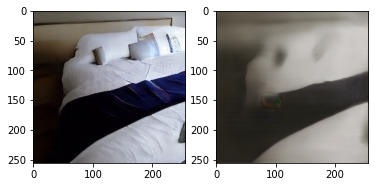

In [ ]:
pyplot.figure()
pyplot.subplot(1, 2, 1)
pyplot.imshow((images2[2].cpu().clamp(-1, 1).permute(1, 2, 0).detach().numpy() + 1) / 2) 
pyplot.subplot(1, 2, 2)
pyplot.imshow((nnn[1](nnn[0](aone))[0].cpu().clamp(-1, 1).permute(1, 2, 0).detach().numpy() + 1) / 2) 
pyplot.show()

# Encoding 
- Here we start with a zero latent vector, and optimise it such that the generated image from that latent vector is similar to our reference image. This methodology involves working with images one by one and generating corresponding latent vectors.

In [ ]:
drive_file = '/content/drive/My\ Drive/CV_Project'
path = os.getcwd()
count = 1

#renmaing the filenames to 1, 2, 3, 4 .jpg
import glob
for file1 in glob.glob(drive_file +"/bedrooms" + "*/*.jpg"):
    os.rename(file1, os.path.join(drive_file+"/bedrooms/bedroom{}.jpg".format(count)))
    count += 1
    if count > 100:
        break
    print(". ", end=' ')



.  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  

In [ ]:
paths = os.getcwd()
path1 = lambda i: drive_file+"/bedroom{}".format(i)

In [ ]:
!ls /content/drive/My\ Drive/CV_Project/


bedroom10.jpg  bedroom23.jpg  bedroom36.jpg  bedroom49.jpg  bedroom61.jpg
bedroom11.jpg  bedroom24.jpg  bedroom37.jpg  bedroom4.jpg   bedroom62.jpg
bedroom12.jpg  bedroom25.jpg  bedroom38.jpg  bedroom50.jpg  bedroom63.jpg
bedroom13.jpg  bedroom26.jpg  bedroom39.jpg  bedroom51.jpg  bedroom64.jpg
bedroom14.jpg  bedroom27.jpg  bedroom3.jpg   bedroom52.jpg  bedroom65.jpg
bedroom15.jpg  bedroom28.jpg  bedroom40.jpg  bedroom53.jpg  bedroom66.jpg
bedroom16.jpg  bedroom29.jpg  bedroom41.jpg  bedroom54.jpg  bedroom67.jpg
bedroom17.jpg  bedroom2.jpg   bedroom42.jpg  bedroom55.jpg  bedroom6.jpg
bedroom18.jpg  bedroom30.jpg  bedroom43.jpg  bedroom56.jpg  bedroom7.jpg
bedroom19.jpg  bedroom31.jpg  bedroom44.jpg  bedroom57.jpg  bedroom8.jpg
bedroom1.jpg   bedroom32.jpg  bedroom45.jpg  bedroom58.jpg  bedroom9.jpg
bedroom20.jpg  bedroom33.jpg  bedroom46.jpg  bedroom59.jpg
bedroom21.jpg  bedroom34.jpg  bedroom47.jpg  bedroom5.jpg
bedroom22.jpg  bedroom35.jpg  bedroom48.jpg  bedroom60.jpg


In [ ]:
#classes useful for encoding

class PostSynthesisProcessing(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.min_value = -1
        self.max_value = 1

    def forward(self, synthesized_image):
        synthesized_image = (synthesized_image - self.min_value) * torch.tensor(255).float() / (self.max_value - self.min_value)
        synthesized_image = torch.clamp(synthesized_image + 0.5, min=0, max=255)

        return synthesized_image


class ImageToLatent(torch.nn.Module):
    def __init__(self, image_size=256):
        super().__init__()
        
        self.image_size = image_size
        self.activation = torch.nn.ELU()
        
        self.resnet = list(resnet50(pretrained=True).children())[:-2]
        self.resnet = torch.nn.Sequential(*self.resnet)
        self.conv2d = torch.nn.Conv2d(2048, 256, kernel_size=1)
        self.flatten = torch.nn.Flatten()
        self.dense1 = torch.nn.Linear(1024, 512)
        self.dense2 = torch.nn.Linear(512, 256)
        self.dense3 = torch.nn.Linear(256, (14 * 512))

    def forward(self, image):
        x = self.resnet(image)
        x = self.conv2d(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = nn.leaky_relu(x)
        x = self.dense2(x)
        x = nn.leaky_relu(x)
        x = self.dense3(x)
        x = x.view((-1, 14, 512))

        return x

In [ ]:
drive_file = '/content/drive/My Drive/CV_Project'
os.chdir(drive_file)
print(os.getcwd())

/content/drive/My Drive/CV_Project


In [ ]:
import torch.nn.functional as F
from torchvision.models import vgg16
import torchvision
from tqdm import tqdm
import numpy as np
import torch
import torch
from torchvision.models import resnet50
from PIL import Image
import cv2
import numpy as np

def load_images(filenames):
    # Images must all be of same shape.
    images = []
    for filename in filenames:
        temp_image = np.asarray(Image.open(filename))        
        # Adjust channel dimension to work with torch.
        temp_image = np.transpose(temp_image, (2,0,1))
        images.append(temp_image)

    return np.array(images)

def save_image(image, save_path):
    image = np.transpose(image, (1,2,0)).astype(np.uint8)
    image = Image.fromarray(image)
    image.save(save_path)

class VGGProcessing(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.image_size = 256
        self.mean = torch.tensor([0.485, 0.456, 0.406], device="cuda").view(-1, 1, 1)
        self.std = torch.tensor([0.229, 0.224, 0.225], device="cuda").view(-1, 1, 1)

    def forward(self, image):
        image = image / torch.tensor(255).float()
        image = F.adaptive_avg_pool2d(image, self.image_size)

        image = (image - self.mean) / self.std

        return image


class LatentOptimizer(torch.nn.Module):
    def __init__(self, synthesizer, layer=12):
        super().__init__()

        self.synthesizer = synthesizer.cuda().eval()
        self.post_synthesis_processing = PostSynthesisProcessing()
        self.vgg_processing = VGGProcessing()
        self.vgg16 = vgg16(pretrained=True).features[:layer].cuda().eval()


    def forward(self, dlatents):
        generated_image = self.synthesizer(dlatents)
        generated_image = self.post_synthesis_processing(generated_image)
        generated_image = self.vgg_processing(generated_image)
        features = self.vgg16(generated_image)

        return generated_image, features




In [ ]:
def rayyan_loss(reference_image, generated_image, generated_image_features, reference_features):
    percep_pixel = torch.mean((reference_features - generated_image_features) ** 2) + torch.mean((reference_image - generated_image) ** 2) * 5
    percep =  torch.mean((reference_features - generated_image_features) ** 2) 
    return percep

Step: 0, Loss: 11.266813278198242	Step: 100, Loss: 4.745880126953125	Step: 200, Loss: 4.634257793426514	Step: 300, Loss: 4.350211143493652	Step: 400, Loss: 4.142780303955078	Step: 500, Loss: 4.001343727111816	Step: 600, Loss: 3.9372105598449707	Step: 700, Loss: 3.794363021850586	Step: 800, Loss: 3.6781647205352783	Step: 900, Loss: 3.730924129486084	Step: 1000, Loss: 3.5989532470703125	Step: 1100, Loss: 3.549468517303467	Step: 1200, Loss: 3.5664267539978027	Step: 1300, Loss: 3.5526235103607178	Step: 1400, Loss: 3.425548791885376	Step: 1500, Loss: 3.406205892562866	Step: 1600, Loss: 3.376539707183838	Step: 1700, Loss: 3.33858585357666	Step: 1800, Loss: 3.4019792079925537	Step: 1900, Loss: 3.394379138946533	
torch.Size([1, 3, 256, 256])
0th image, learning dlatents


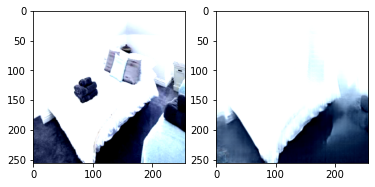

Step: 0, Loss: 12.799506187438965	Step: 100, Loss: 6.057153701782227	Step: 200, Loss: 5.778794765472412	Step: 300, Loss: 5.474498271942139	Step: 400, Loss: 5.331379413604736	Step: 500, Loss: 5.200535774230957	Step: 600, Loss: 5.059955596923828	Step: 700, Loss: 4.951785087585449	Step: 800, Loss: 4.967379570007324	Step: 900, Loss: 4.782782554626465	Step: 1000, Loss: 4.945822238922119	Step: 1100, Loss: 4.598365783691406	Step: 1200, Loss: 4.574796199798584	Step: 1300, Loss: 4.510637283325195	Step: 1400, Loss: 4.392365455627441	Step: 1500, Loss: 4.466641902923584	Step: 1600, Loss: 4.233077049255371	Step: 1700, Loss: 4.288898944854736	Step: 1800, Loss: 4.4525017738342285	Step: 1900, Loss: 4.181724548339844	
Step: 0, Loss: 20.00906753540039	Step: 100, Loss: 14.01970100402832	Step: 200, Loss: 13.08604621887207	Step: 300, Loss: 13.168478012084961	Step: 400, Loss: 12.47210693359375	Step: 500, Loss: 12.741301536560059	Step: 600, Loss: 12.398984909057617	Step: 700, Loss: 11.615294456481934	Step: 8

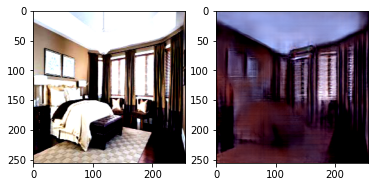

Step: 0, Loss: 16.349197387695312	Step: 100, Loss: 9.304893493652344	Step: 200, Loss: 8.84994125366211	Step: 300, Loss: 8.081250190734863	Step: 400, Loss: 7.824082374572754	Step: 500, Loss: 7.849579811096191	Step: 600, Loss: 7.451079368591309	Step: 700, Loss: 7.326580047607422	Step: 800, Loss: 7.115081787109375	Step: 900, Loss: 6.804897308349609	Step: 1000, Loss: 6.713334083557129	Step: 1100, Loss: 6.807497024536133	Step: 1200, Loss: 6.649673938751221	Step: 1300, Loss: 6.4691667556762695	Step: 1400, Loss: 6.479086875915527	Step: 1500, Loss: 6.482532501220703	Step: 1600, Loss: 6.255707740783691	Step: 1700, Loss: 6.535186767578125	Step: 1800, Loss: 6.2627153396606445	Step: 1900, Loss: 6.330402851104736	
Step: 0, Loss: 15.03736400604248	Step: 100, Loss: 8.862591743469238	Step: 200, Loss: 8.377979278564453	Step: 300, Loss: 8.220855712890625	Step: 400, Loss: 7.848897933959961	Step: 500, Loss: 7.714219093322754	Step: 600, Loss: 7.616706848144531	Step: 700, Loss: 7.092743873596191	Step: 800, 

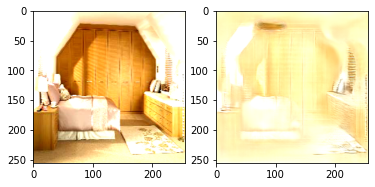

Step: 0, Loss: 13.626321792602539	Step: 100, Loss: 7.354343414306641	Step: 200, Loss: 6.888066291809082	Step: 300, Loss: 6.695333957672119	Step: 400, Loss: 6.348206043243408	Step: 500, Loss: 5.909993648529053	Step: 600, Loss: 6.571719646453857	Step: 700, Loss: 5.789419174194336	Step: 800, Loss: 5.519139766693115	Step: 900, Loss: 5.472467422485352	Step: 1000, Loss: 5.302431106567383	Step: 1100, Loss: 4.997220039367676	Step: 1200, Loss: 4.932560920715332	Step: 1300, Loss: 5.2408857345581055	Step: 1400, Loss: 4.785088539123535	Step: 1500, Loss: 4.8835530281066895	Step: 1600, Loss: 4.8893842697143555	Step: 1700, Loss: 5.177950382232666	Step: 1800, Loss: 4.630584716796875	Step: 1900, Loss: 4.6548967361450195	
Step: 0, Loss: 12.179445266723633	Step: 100, Loss: 4.62548828125	Step: 200, Loss: 4.337465286254883	Step: 300, Loss: 4.116481304168701	Step: 400, Loss: 4.045589447021484	Step: 500, Loss: 3.940025568008423	Step: 600, Loss: 3.825115919113159	Step: 700, Loss: 3.664940357208252	Step: 800, 

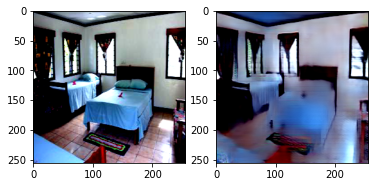

Step: 0, Loss: 16.485553741455078	Step: 100, Loss: 9.988513946533203	Step: 200, Loss: 9.364023208618164	Step: 300, Loss: 9.033599853515625	Step: 400, Loss: 8.523584365844727	Step: 500, Loss: 8.252742767333984	Step: 600, Loss: 8.212373733520508	Step: 700, Loss: 7.787594318389893	Step: 800, Loss: 8.297404289245605	Step: 900, Loss: 7.601996421813965	Step: 1000, Loss: 7.5758185386657715	Step: 1100, Loss: 7.450240135192871	Step: 1200, Loss: 7.322957992553711	Step: 1300, Loss: 7.6816205978393555	Step: 1400, Loss: 6.969533443450928	Step: 1500, Loss: 6.888757705688477	Step: 1600, Loss: 6.658801555633545	Step: 1700, Loss: 6.965624809265137	Step: 1800, Loss: 6.697509765625	Step: 1900, Loss: 6.861531734466553	
Step: 0, Loss: 13.430075645446777	Step: 100, Loss: 6.888552665710449	Step: 200, Loss: 6.681084156036377	Step: 300, Loss: 6.427087783813477	Step: 400, Loss: 6.212629795074463	Step: 500, Loss: 6.016443252563477	Step: 600, Loss: 5.780773162841797	Step: 700, Loss: 5.607525825500488	Step: 800, L

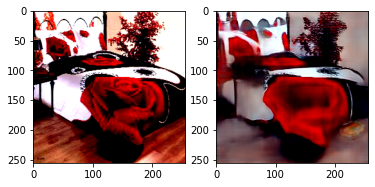

Step: 0, Loss: 13.023397445678711	Step: 100, Loss: 6.306635856628418	Step: 200, Loss: 6.059926986694336	Step: 300, Loss: 5.269491672515869	Step: 400, Loss: 5.167464256286621	Step: 500, Loss: 4.94875431060791	Step: 600, Loss: 4.799126148223877	Step: 700, Loss: 4.786833763122559	Step: 800, Loss: 4.5300493240356445	Step: 900, Loss: 4.390229225158691	Step: 1000, Loss: 4.386800289154053	Step: 1100, Loss: 4.605304718017578	Step: 1200, Loss: 4.184356689453125	Step: 1300, Loss: 4.057888984680176	Step: 1400, Loss: 4.19126558303833	Step: 1500, Loss: 4.012223243713379	Step: 1600, Loss: 3.914705753326416	Step: 1700, Loss: 4.0750274658203125	Step: 1800, Loss: 3.90771484375	Step: 1900, Loss: 3.7713656425476074	
Step: 0, Loss: 12.642706871032715	Step: 100, Loss: 6.008586883544922	Step: 200, Loss: 5.590585708618164	Step: 300, Loss: 5.414844512939453	Step: 400, Loss: 5.324129104614258	Step: 500, Loss: 5.096380233764648	Step: 600, Loss: 5.131701469421387	Step: 700, Loss: 4.992389678955078	Step: 800, Los

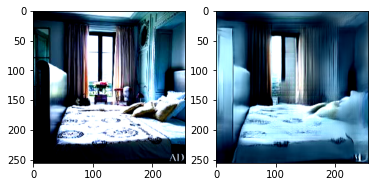

Step: 0, Loss: 13.9303560256958	Step: 100, Loss: 8.082202911376953	Step: 200, Loss: 7.738438606262207	Step: 300, Loss: 7.371371269226074	Step: 400, Loss: 7.213371276855469	Step: 500, Loss: 7.093705654144287	Step: 600, Loss: 7.044828414916992	Step: 700, Loss: 7.058689117431641	Step: 800, Loss: 6.715356826782227	Step: 900, Loss: 6.466937065124512	Step: 1000, Loss: 6.369292259216309	Step: 1100, Loss: 6.553893089294434	Step: 1200, Loss: 6.314975261688232	Step: 1300, Loss: 6.680234909057617	Step: 1400, Loss: 6.224944591522217	Step: 1500, Loss: 6.146302700042725	Step: 1600, Loss: 6.0953803062438965	Step: 1700, Loss: 6.176652431488037	Step: 1800, Loss: 5.900567054748535	Step: 1900, Loss: 5.89549446105957	
Step: 0, Loss: 16.73835563659668	Step: 100, Loss: 10.102758407592773	Step: 200, Loss: 9.232898712158203	Step: 300, Loss: 9.155370712280273	Step: 400, Loss: 8.806181907653809	Step: 500, Loss: 8.203219413757324	Step: 600, Loss: 7.795474052429199	Step: 700, Loss: 8.116728782653809	Step: 800, Lo

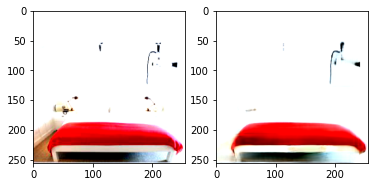

Step: 0, Loss: 15.195842742919922	Step: 100, Loss: 8.836240768432617	Step: 200, Loss: 8.382843017578125	Step: 300, Loss: 7.955496788024902	Step: 400, Loss: 7.767900466918945	Step: 500, Loss: 7.469270706176758	Step: 600, Loss: 7.478682994842529	Step: 700, Loss: 7.180460453033447	Step: 800, Loss: 7.214208602905273	Step: 900, Loss: 6.9436187744140625	Step: 1000, Loss: 6.871788501739502	Step: 1100, Loss: 6.843069076538086	Step: 1200, Loss: 6.765703201293945	Step: 1300, Loss: 6.547696113586426	Step: 1400, Loss: 6.543483734130859	Step: 1500, Loss: 6.460082054138184	Step: 1600, Loss: 6.551582336425781	Step: 1700, Loss: 6.481637477874756	Step: 1800, Loss: 6.31362771987915	Step: 1900, Loss: 6.293980121612549	
Step: 0, Loss: 14.041108131408691	Step: 100, Loss: 7.906713962554932	Step: 200, Loss: 7.056902885437012	Step: 300, Loss: 6.624790191650391	Step: 400, Loss: 6.197410583496094	Step: 500, Loss: 6.122214317321777	Step: 600, Loss: 5.750492572784424	Step: 700, Loss: 5.763956069946289	Step: 800, 

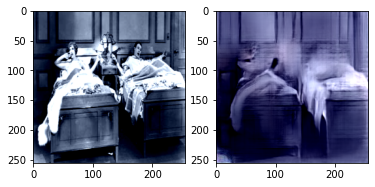

Step: 0, Loss: 15.080194473266602	Step: 100, Loss: 8.654731750488281	Step: 200, Loss: 8.478361129760742	Step: 300, Loss: 7.0388503074646	Step: 400, Loss: 6.910032749176025	Step: 500, Loss: 6.076639652252197	Step: 600, Loss: 6.246562480926514	Step: 700, Loss: 5.808989524841309	Step: 800, Loss: 5.81650447845459	Step: 900, Loss: 5.381420135498047	Step: 1000, Loss: 5.462759971618652	Step: 1100, Loss: 5.5002946853637695	Step: 1200, Loss: 4.938612937927246	Step: 1300, Loss: 5.0230255126953125	Step: 1400, Loss: 4.84868049621582	Step: 1500, Loss: 4.8343915939331055	Step: 1600, Loss: 5.086794853210449	Step: 1700, Loss: 4.732030868530273	Step: 1800, Loss: 4.437180519104004	Step: 1900, Loss: 4.568845748901367	
Step: 0, Loss: 13.10494327545166	Step: 100, Loss: 7.352778911590576	Step: 200, Loss: 6.835824966430664	Step: 300, Loss: 6.483010768890381	Step: 400, Loss: 6.35709285736084	Step: 500, Loss: 6.036105155944824	Step: 600, Loss: 6.009345054626465	Step: 700, Loss: 5.9250102043151855	Step: 800, Lo

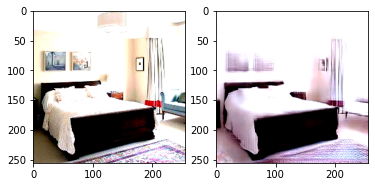

Step: 0, Loss: 13.368368148803711	Step: 100, Loss: 6.867374420166016	Step: 200, Loss: 6.605363845825195	Step: 300, Loss: 6.47503662109375	Step: 400, Loss: 6.3441481590271	Step: 500, Loss: 6.110777378082275	Step: 600, Loss: 6.038208961486816	Step: 700, Loss: 5.910493850708008	Step: 800, Loss: 5.931557655334473	Step: 900, Loss: 5.7951860427856445	Step: 1000, Loss: 5.6726202964782715	Step: 1100, Loss: 5.702966213226318	Step: 1200, Loss: 5.62100887298584	Step: 1300, Loss: 5.666446685791016	Step: 1400, Loss: 5.430736541748047	Step: 1500, Loss: 5.4560699462890625	Step: 1600, Loss: 5.495762348175049	Step: 1700, Loss: 5.355739593505859	Step: 1800, Loss: 5.467952251434326	Step: 1900, Loss: 5.372029781341553	
Step: 0, Loss: 14.71483039855957	Step: 100, Loss: 8.607523918151855	Step: 200, Loss: 8.116914749145508	Step: 300, Loss: 7.781953811645508	Step: 400, Loss: 7.627978324890137	Step: 500, Loss: 7.493697643280029	Step: 600, Loss: 7.34720516204834	Step: 700, Loss: 7.089883804321289	Step: 800, Los

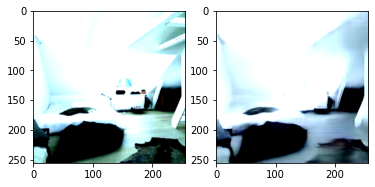

Step: 0, Loss: 16.95172119140625	Step: 100, Loss: 10.797115325927734	Step: 200, Loss: 10.40294361114502	Step: 300, Loss: 9.880866050720215	Step: 400, Loss: 9.164953231811523	Step: 500, Loss: 9.054329872131348	Step: 600, Loss: 8.930294036865234	Step: 700, Loss: 8.766432762145996	Step: 800, Loss: 8.672969818115234	Step: 900, Loss: 8.204044342041016	Step: 1000, Loss: 8.38052749633789	Step: 1100, Loss: 7.8770060539245605	Step: 1200, Loss: 7.7530436515808105	Step: 1300, Loss: 7.994131565093994	Step: 1400, Loss: 7.684621810913086	Step: 1500, Loss: 7.72257137298584	Step: 1600, Loss: 7.717374801635742	Step: 1700, Loss: 7.381803512573242	Step: 1800, Loss: 7.415337562561035	Step: 1900, Loss: 7.1439528465271	
Step: 0, Loss: 10.495731353759766	Step: 100, Loss: 3.512571334838867	Step: 200, Loss: 3.369539260864258	Step: 300, Loss: 3.2075090408325195	Step: 400, Loss: 3.069489002227783	Step: 500, Loss: 3.063037395477295	Step: 600, Loss: 2.9755537509918213	Step: 700, Loss: 2.905299425125122	Step: 800, 

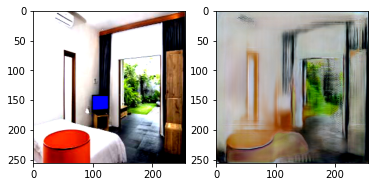

Step: 0, Loss: 19.394222259521484	Step: 100, Loss: 13.060020446777344	Step: 200, Loss: 12.564621925354004	Step: 300, Loss: 12.663207054138184	Step: 400, Loss: 12.228071212768555	Step: 500, Loss: 11.59428882598877	Step: 600, Loss: 11.523880004882812	Step: 700, Loss: 11.409835815429688	Step: 800, Loss: 11.227424621582031	Step: 900, Loss: 10.94711685180664	Step: 1000, Loss: 10.756081581115723	Step: 1100, Loss: 10.638721466064453	Step: 1200, Loss: 10.539762496948242	Step: 1300, Loss: 10.714278221130371	Step: 1400, Loss: 10.590425491333008	Step: 1500, Loss: 10.408027648925781	Step: 1600, Loss: 10.320115089416504	Step: 1700, Loss: 10.378787994384766	Step: 1800, Loss: 10.330551147460938	Step: 1900, Loss: 10.182924270629883	
Step: 0, Loss: 18.5235595703125	Step: 100, Loss: 12.445745468139648	Step: 200, Loss: 11.798952102661133	Step: 300, Loss: 11.697437286376953	Step: 400, Loss: 11.225116729736328	Step: 500, Loss: 11.162580490112305	Step: 600, Loss: 10.895320892333984	Step: 700, Loss: 10.64296

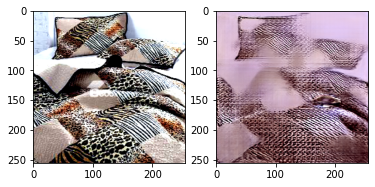

Step: 0, Loss: 12.89377212524414	Step: 100, Loss: 6.45454216003418	Step: 200, Loss: 5.887790679931641	Step: 300, Loss: 5.601930618286133	Step: 400, Loss: 4.932024955749512	Step: 500, Loss: 4.822645664215088	Step: 600, Loss: 4.613643646240234	Step: 700, Loss: 4.204816818237305	Step: 800, Loss: 4.244004726409912	Step: 900, Loss: 4.228534698486328	Step: 1000, Loss: 4.229470252990723	Step: 1100, Loss: 3.873116970062256	Step: 1200, Loss: 3.888415813446045	Step: 1300, Loss: 3.5873212814331055	Step: 1400, Loss: 3.6643424034118652	Step: 1500, Loss: 3.7034058570861816	Step: 1600, Loss: 3.6381125450134277	Step: 1700, Loss: 3.652358055114746	Step: 1800, Loss: 3.607236862182617	Step: 1900, Loss: 3.497344970703125	
Step: 0, Loss: 13.97484016418457	Step: 100, Loss: 7.441048622131348	Step: 200, Loss: 7.045057773590088	Step: 300, Loss: 6.853033542633057	Step: 400, Loss: 6.884527206420898	Step: 500, Loss: 6.630584716796875	Step: 600, Loss: 6.520195960998535	Step: 700, Loss: 6.375941753387451	Step: 800,

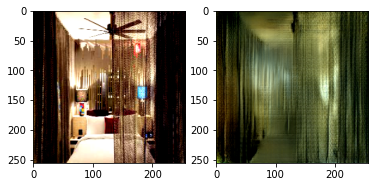

Step: 0, Loss: 12.47125244140625	Step: 100, Loss: 6.288446426391602	Step: 200, Loss: 5.940682888031006	Step: 300, Loss: 5.639395713806152	Step: 400, Loss: 5.556896209716797	Step: 500, Loss: 5.095404624938965	Step: 600, Loss: 5.098479270935059	Step: 700, Loss: 4.799182891845703	Step: 800, Loss: 4.64639139175415	Step: 900, Loss: 4.977754592895508	Step: 1000, Loss: 4.6175713539123535	Step: 1100, Loss: 4.516332149505615	Step: 1200, Loss: 4.300508499145508	Step: 1300, Loss: 4.298823356628418	Step: 1400, Loss: 4.277695178985596	Step: 1500, Loss: 4.172420501708984	Step: 1600, Loss: 4.014782905578613	Step: 1700, Loss: 4.104504585266113	Step: 1800, Loss: 4.009937286376953	Step: 1900, Loss: 3.913378953933716	
Step: 0, Loss: 15.424993515014648	Step: 100, Loss: 8.731849670410156	Step: 200, Loss: 8.248922348022461	Step: 300, Loss: 7.350639820098877	Step: 400, Loss: 7.733841896057129	Step: 500, Loss: 7.052914619445801	Step: 600, Loss: 6.5943603515625	Step: 700, Loss: 5.882493019104004	Step: 800, Los

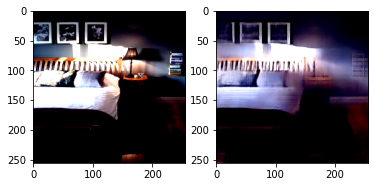

Step: 0, Loss: 14.006379127502441	Step: 100, Loss: 8.171712875366211	Step: 200, Loss: 7.667240142822266	Step: 300, Loss: 7.769688129425049	Step: 400, Loss: 7.395456314086914	Step: 500, Loss: 7.202237606048584	Step: 600, Loss: 6.668612957000732	Step: 700, Loss: 6.704419136047363	Step: 800, Loss: 6.618717193603516	Step: 900, Loss: 6.701171398162842	Step: 1000, Loss: 6.429240703582764	Step: 1100, Loss: 6.6339545249938965	Step: 1200, Loss: 6.022522449493408	Step: 1300, Loss: 5.977051734924316	Step: 1400, Loss: 5.95556640625	Step: 1500, Loss: 5.886167526245117	Step: 1600, Loss: 5.910999298095703	Step: 1700, Loss: 5.801723480224609	Step: 1800, Loss: 5.549469470977783	Step: 1900, Loss: 5.572299003601074	


FileNotFoundError: ignored

In [ ]:
synthesizer = g_all.g_synthesis
latent_optimizer = LatentOptimizer(synthesizer)

# Optimize only the dlatents.
for param in latent_optimizer.parameters():
    param.requires_grad_(False)

losses = dict()
for i in range(count): #only generating latents for a subset as it is computationally inefficient.    
    reference_image = load_images([path1(i+1)+'.jpg'])
    reference_image = torch.from_numpy(reference_image).cuda()
    reference_image = latent_optimizer.vgg_processing(reference_image)
    reference_features = latent_optimizer.vgg16(reference_image).detach()
    reference_image = reference_image.detach()
    latents_to_be_optimized = torch.zeros((1,14,512)).cuda().requires_grad_(True)

    criterion = rayyan_loss
    optimizer = torch.optim.SGD([latents_to_be_optimized], lr=1) #tried small lrs as well. also tried Adam

    for step in range(2000): #also tried 500, 1000, 5000 
        optimizer.zero_grad()

        generated_image, generated_image_features = latent_optimizer(latents_to_be_optimized)
        
        l = criterion(reference_image, generated_image, generated_image_features, reference_features)
        l.backward()
        l = l.item()

        optimizer.step()
        if step%100 == 0:
            print("Step: {}, Loss: {}".format(step, l), end = '\t')
    print()
    losses[path(i+1)] = l
    if i%5 == 0:
        generated_image, _ = latent_optimizer(latents_to_be_optimized)
        print(reference_image.shape)
        print("{}th image, learning dlatents".format(i))
        pyplot.figure()
        #pyplot.subplot(20, 5, i+1)
        pyplot.subplot(1, 2, 1)
        pyplot.imshow((reference_image.view(3, 256, 256).cpu().clamp(-1, 1).permute(1, 2, 0).detach().numpy() + 1) / 2) 
        pyplot.subplot(1, 2, 2)
        pyplot.imshow((generated_image.view(3, 256, 256).cpu().clamp(-1, 1).permute(1, 2, 0).detach().numpy() + 1) / 2)
        pyplot.show()
    optimized_dlatents = latents_to_be_optimized.detach().cpu().numpy()
    #np.save(path(i+1)+str('.npy'), optimized_dlatents)
    np.save(path1(i+1)+str('.npy'), optimized_dlatents)


In [ ]:
!zip -r ./bd.zip ./bedrooms

  adding: bedrooms/ (stored 0%)
  adding: bedrooms/bedroom20.jpg (deflated 1%)
  adding: bedrooms/bedroom35.jpg (deflated 1%)
  adding: bedrooms/bedroom42.jpg (deflated 1%)
  adding: bedrooms/bedroom54.jpg (deflated 1%)
  adding: bedrooms/bedroom29.jpg (deflated 1%)
  adding: bedrooms/bedroom7.jpg (deflated 1%)
  adding: bedrooms/bedroom61.jpg (deflated 1%)
  adding: bedrooms/bedroom9.jpg (deflated 1%)
  adding: bedrooms/bedroom36.jpg (deflated 1%)
  adding: bedrooms/bedroom21.jpg (deflated 1%)
  adding: bedrooms/bedroom37.jpg (deflated 2%)
  adding: bedrooms/bedroom26.jpg (deflated 1%)
  adding: bedrooms/bedroom40.jpg (deflated 3%)
  adding: bedrooms/bedroom60.jpg (deflated 1%)
  adding: bedrooms/bedroom55.jpg (deflated 1%)
  adding: bedrooms/bedroom65.jpg (deflated 1%)
  adding: bedrooms/bedroom45.jpg (deflated 1%)
  adding: bedrooms/bedroom11.jpg (deflated 1%)
  adding: bedrooms/bedroom10.jpg (deflated 1%)
  adding: bedrooms/bedroom34.jpg (deflated 1%)
  adding: bedrooms/bedroom32.j

In [ ]:
#saving losses corresponding to encoding as a csv file for later use.
sorted_losses = collections.OrderedDict(losses)
import pandas as pd
df = pd.DataFrame.from_dict(losses, orient="index")
df.to_csv(drive_file+'/losses.csv', index=False)
pd.read_csv(drive_file+'/losses.csv').head()